In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Data Story Telling Notebook

This notebook is concerned with investigating the relationship between GME stock prices and key indicators to several of the topics derived from the LDA topic modeling done on the WallStreetBets posts and comments data that I scraped from the reddit API using PSAW.

Of the 65 topics determined by our model 12 of them were interpretable, meaning a central theme could be determined by looking at the combined words. We are primarily interested in looking at these different time series to detect any possible leader/follower behavior before the Jan '21 short squeeze of GME stocks. 

The 12 topics we shall be looking into are:

    - 0: long/short term trading advice
    - 9: Trump tax plan
    - 18: 2020 election
    - 22: increase gme price/short squeeze
    - 25: market trends bear/bull
    - 27: legalization of Marijuana
    - 32: trading with robinhood
    - 34: price per barrel of oil
    - 37: covid vaccinations
    - 48: corn
    - 55: spacex mining asteroids, batteries
    - 58: quarterly earnings reports

On the part of GME stocks we are going to primarily look at the VWAP, RSI, and stochastic-RSI indicators.

We shall be conducting correlation tests over the training period and validation period to see how trends align across these time frames. Furthermore we shall be looking at several other indicators of relationship such as: Windowed pearson correlation, Dynamic Time Warping, and Time Lagged Cross Correlation.

This project has been considered from the perspective of a large scale financial institution that is seeking to minimize loss in the future. Seeing the organizational power demonstrated by the WSB community, was there any indication of potential acting power in advance of the Jan. '21 event? Can we derive topics from the corpus of posts and comments to determine correlation in price momentum? Here is where we seek to do just that.

In [11]:
keep_topics = [0,9,18,22,25,27,32,34,37,48,55,58]

In [12]:
!pip install dtw

In [13]:
import pandas as pd
import numpy as np
import pathlib

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

In [14]:
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [15]:
from dtw import dtw,accelerated_dtw

In [16]:
#!pip install --upgrade statsmodels

In [85]:
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

In [18]:
sns.set_style('darkgrid')

In [19]:
cwd = pathlib.Path.cwd()
cst_loc = cwd / 'gdrive/My Drive/Capstone_two'

## Topic Frequencies


In [20]:
df_one = pd.read_pickle(cst_loc/'training_labeled.pkl')

In [21]:
topic_frequencies = df_one.groupby(['dt','primary_topic'])['id'].count().reset_index()

In [22]:
topic_pivot = topic_frequencies.pivot(index='dt', columns=['primary_topic'], values='id')

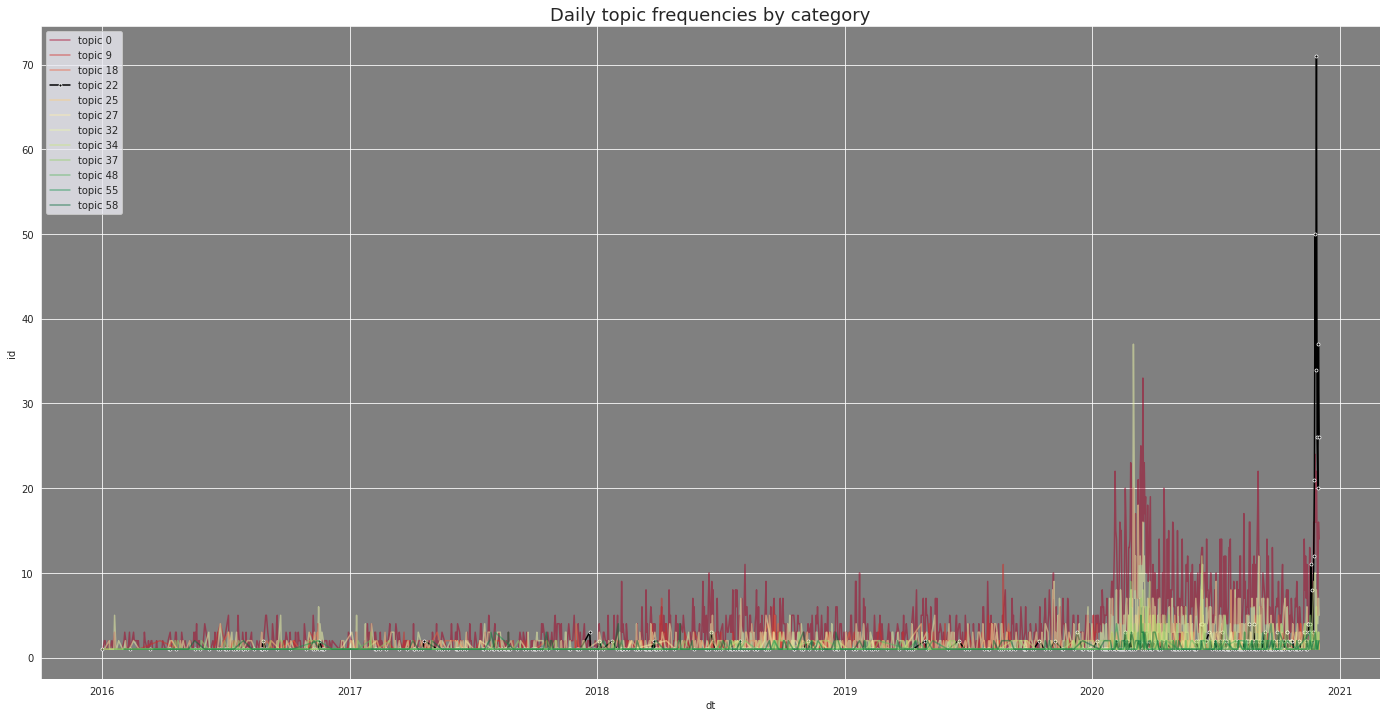

In [23]:
colors = [cm.RdYlGn(i) for i in np.linspace(0,1,12)]

_, ax = plt.subplots(1,1,figsize=(24,12))
ax.set_facecolor('gray')
for i in range(len(keep_topics)):
    data = topic_frequencies[topic_frequencies.primary_topic == keep_topics[i]]
    if keep_topics[i] == 22:
        sns.lineplot(data = data, x='dt', y='id', color='black', marker='.', label=f'topic {keep_topics[i]}')
    else:
        sns.lineplot(data = data, x='dt', y='id', color=colors[i], label=f'topic {keep_topics[i]}', alpha=0.5)

ax.set_title('Daily topic frequencies by category', fontsize=18)

plt.show()

Looking at the per day topic frequencies from 2016-01-01 until 2020-12-01 there appears to be an interesting increase in topic 0 frequencies in the first quater of 2018.

In [24]:
df_two = pd.read_pickle(cst_loc/'validation_labeled.pkl')

In [25]:
val_topics = df_two.groupby(['dt','primary_topic'])['id'].count().reset_index()

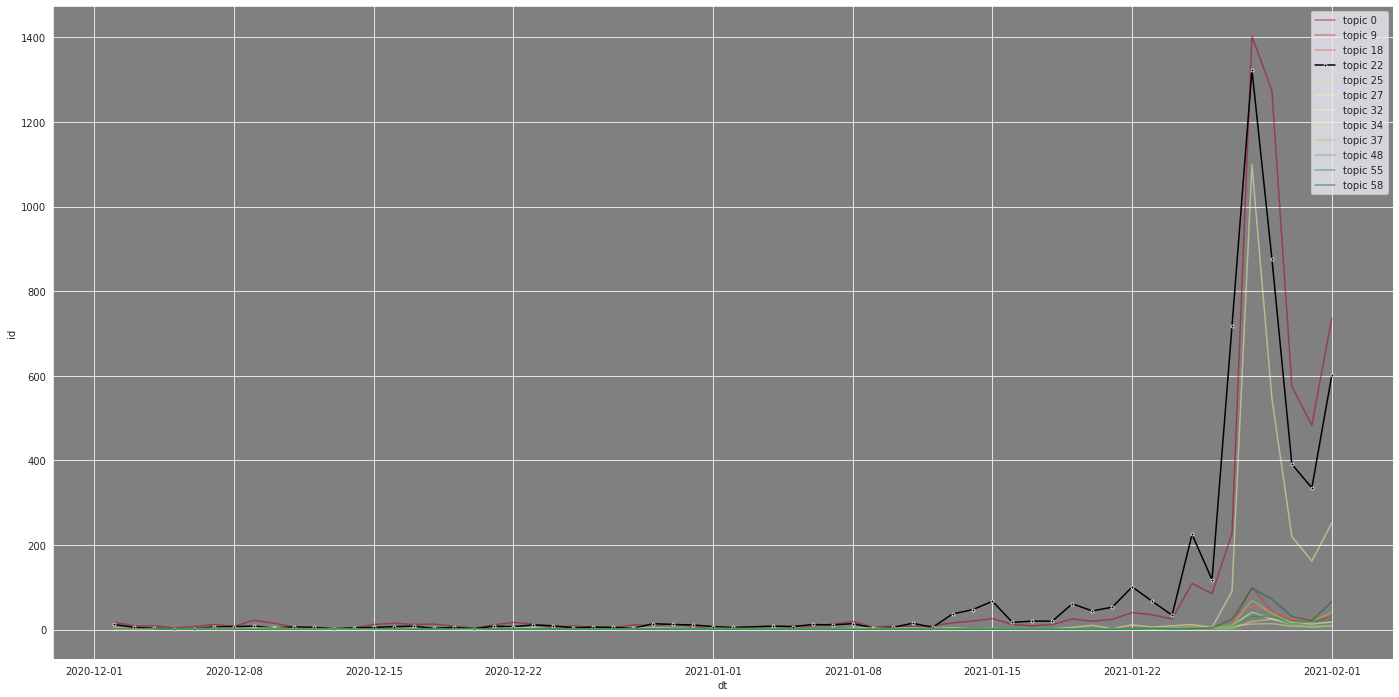

In [26]:
colors = [cm.RdYlGn(i) for i in np.linspace(0,1,12)]

_, ax = plt.subplots(1,1,figsize=(24,12))
ax.set_facecolor('gray')

for i in range(len(keep_topics)):
    data = val_topics[val_topics.primary_topic == keep_topics[i]]
    if keep_topics[i] == 22:
        sns.lineplot(data = data, x='dt', y='id', color='black', marker='.',label=f'topic {keep_topics[i]}')
    else:
        sns.lineplot(data = data, x='dt', y='id', color=colors[i],label=f'topic {keep_topics[i]}', alpha = 0.5)
plt.show()

In [27]:
whole = pd.concat([topic_frequencies, val_topics], ignore_index=True).reset_index()

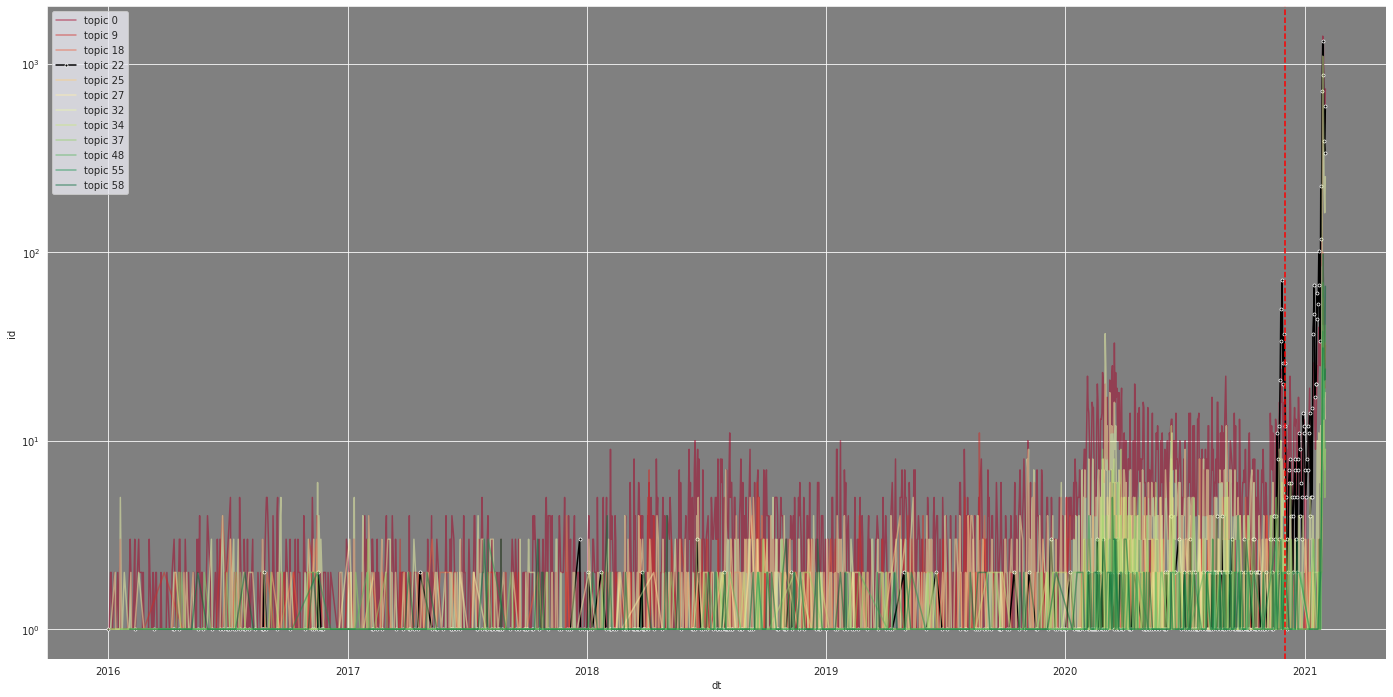

In [28]:
colors = [cm.RdYlGn(i) for i in np.linspace(0,1,12)]

_, ax = plt.subplots(1,1,figsize=(24,12))
ax.set_facecolor('gray')

for i in range(12):
    data = whole[whole.primary_topic == keep_topics[i]]
    if keep_topics[i] == 22:
        sns.lineplot(data = data, x='dt', y='id', color='black', marker='.',label=f'topic {keep_topics[i]}')
    else:
        sns.lineplot(data = data, x='dt', y='id', color=colors[i],label=f'topic {keep_topics[i]}', alpha=0.5)

ax.axvline(x=pd.to_datetime('2020-12-02'), color='red', linestyle='--')
ax.set_yscale('log')
plt.show()

In [29]:
whole_pivoted = whole.pivot(index='dt', columns=['primary_topic'], values='id').fillna(0)
whole_pivoted = whole_pivoted[keep_topics]

In [30]:
df_prices = pd.read_csv(cst_loc/'price_indicators.csv', parse_dates=['Date'])

In [31]:
df_prices = df_prices.set_index('Date')

In [32]:
df_prices.tail()

Date.1  Close/Last  ...  STOCHRSIk_14_14_3_3  STOCHRSId_14_14_3_3
Date                                ...                                          
2021-01-26  2021-01-26      147.98  ...           100.000000            92.138270
2021-01-27  2021-01-27      347.51  ...           100.000000            97.679059
2021-01-28  2021-01-28      193.60  ...            74.685158            91.561719
2021-01-29  2021-01-29      325.00  ...            51.453744            75.379634
2021-02-01  2021-02-01      225.00  ...            18.120410            48.086437

[5 rows x 13 columns]

In [33]:
df_prices['sma_50'] = df_prices['Close/Last'].rolling(50).mean()
df_prices['std_50'] = df_prices['Close/Last'].rolling(50).std(ddof=0)

In [34]:
df_prices['bbandu'] = df_prices['sma_50'] + 2*df_prices['std_50']
df_prices['bbandl'] = df_prices['sma_50'] - 2*df_prices['std_50']

In [35]:

def make_cdlstk(frame,logscale=False):
    fig = make_subplots(rows = 3, cols = 1, shared_xaxes = True, subplot_titles = ('GME', 'Volume', 'RSI'), vertical_spacing = 0.05, row_width = [0.2, 0.2, 0.5])
    #candlestick plot
    fig.add_trace(go.Candlestick(
        x=frame.index,
        open = frame['Open'],
        high = frame['High'],
        low= frame['Low'],
        close = frame['Close/Last'],
        name='gme_candlestick')
    ,row=1, col=1)
    #sma_50
    fig.add_trace(go.Scatter(
            x=frame.index,
            y = frame['sma_50'],
            line_color='goldenrod',
            name='sma_50')
        ,row=1, col=1)
    #bollingerbands
    fig.add_trace(go.Scatter(
            x=frame.index,
            y=frame['bbandu'],
            line_color='goldenrod',
            line={'dash':'dash'},
            name='upper band',
            opacity=0.5),
        row=1, col=1)
    fig.add_trace(go.Scatter(
            x=frame.index,
            y=frame['bbandl'],
            line_color='goldenrod',
            line={'dash':'dash'},
            fill = 'tonexty',
            name='lower band',
            opacity=0.5),
        row=1, col=1)
    #VWAP
    fig.add_trace(go.Scatter(
            x=frame.index,
            y = frame['VWAP'],
            line_color='green',
            name='vwap',
            opacity=0.5)
        ,row=1, col=1)
    # vwmas
    fig.add_trace(go.Scatter(
            x=frame.index,
            y = frame['VWMA_50'],
            line_color='cyan',
            name='vwma_50',
            opacity=0.5)
        ,row=1, col=1)
    fig.add_trace(go.Scatter(
            x=frame.index,
            y = frame['VWMA_100'],
            line_color='purple',
            name='vwma_100',
            opacity=0.5)
        ,row=1, col=1)
    fig.add_trace(go.Scatter(
            x=frame.index,
            y = frame['VWMA_200'],
            line_color='pink',
            name='vwma_200',
            opacity=0.5)
        ,row=1, col=1)
    #volume
    fig.add_trace(go.Bar(
        x = frame.index,
        y = frame['Volume'],
        name='volume',
        opacity=1,
        marker_color='darkred'),
    row=2, col=1)
    #rsi and stochrsi
    fig.add_trace(go.Scatter(
            x=frame.index,
            y = frame['RSI'],
            line_color='green',
            name='rsi')
        ,row=3, col=1)
    fig.add_trace(go.Scatter(
            x=frame.index,
            y = frame['STOCHRSIk_14_14_3_3'],
            line_color='blue',
            name='stchrsi_k',
            opacity=0.5)
        ,row=3, col=1)
    fig.add_trace(go.Scatter(
            x=frame.index,
            y = frame['STOCHRSId_14_14_3_3'],
            line_color='red',
            name='stchrsi_d',
            opacity=0.5)
        ,row=3, col=1)
    fig.add_trace(go.Scatter(
        name='rsi_80',
        x=[frame.index.min(),frame.index.max()],
        y=[80,80],
        line_color='grey',
        line={'dash':'dash'},
        opacity=0.4
        )
    ,row=3,col=1)

    fig.add_trace(go.Scatter(
        name='rsi_20',
        x=[frame.index.min(),frame.index.max()],
        y=[20,20],
        line_color='grey',
        line={'dash':'dash'},
        fill='tonexty',
        opacity=0.4
        )
    ,row=3,col=1)

    fig.add_trace(go.Scatter(
        name='rsi_70',
        x=[frame.index.min(),frame.index.max()],
        y=[70,70],
        line_color='black',
        line={'dash':'dash'},
        opacity=0.4
        )
    ,row=3,col=1)

    fig.add_trace(go.Scatter(
        name='rsi_30',
        x=[frame.index.min(),frame.index.max()],
        y=[30,30],
        line_color='black',
        line={'dash':'dash'},
        fill='tonexty',
        opacity=0.4
        )
    ,row=3,col=1)

    fig.update(layout_xaxis_rangeslider_visible=False)
    fig.update_layout(height=1200, width=1600)
    if logscale:
        fig.update_yaxes(type='log',row=1,col=1)

    fig.show();


In [36]:
make_cdlstk(df_prices, True)

From the above figure we can see that there is a sustained downward trend in gme stock prices lasting until ~ 2020-08. 

From the RSI we can see that there were historic periods where the price of stocks were driven down and held at low values that one could consider to be undervalued. 

In [37]:
merged = pd.merge(whole_pivoted[keep_topics].fillna(0), df_prices[['VWAP','RSI','STOCHRSIk_14_14_3_3','STOCHRSId_14_14_3_3']], left_index=True, right_index=True, how='outer').interpolate('linear').fillna(0)

In [38]:
merged.tail()

0      9  ...  STOCHRSIk_14_14_3_3  STOCHRSId_14_14_3_3
2021-01-28  1403.0  100.0  ...            74.685158            91.561719
2021-01-29  1274.0   43.0  ...            51.453744            75.379634
2021-01-30   575.0   21.0  ...            40.342633            66.281902
2021-01-31   483.0   19.0  ...            29.231522            57.184170
2021-02-01   736.0   32.0  ...            18.120410            48.086437

[5 rows x 16 columns]

### Pearson Correlation:

We have seen from the above figures that there are different behaviors and patterns over different time periods. It can clearly be see that there is an inverse trend between the selected topics and GME stock prices from 2016 until around 2020-08. That is over this period of time GME stock prices are decreasing with a steady increase in the overall frequency of topics per day on WallStreetBets.

### VWAP
Our first investigation will be against the Volume Weighted Average Price for GME.

In [39]:
for item in merged.columns:
    merged[item] = np.log1p(merged[item])

In [40]:
for item in keep_topics:
    print(f'topic number:{item}',np.corrcoef(merged.loc[:'2020-12-01'][item], merged.loc[:'2020-12-01']['VWAP'])[0,1])

topic number:0 -0.5258270503024522
topic number:9 -0.26544121776508595
topic number:18 -0.2717932383550539
topic number:22 -0.17530576073827672
topic number:25 -0.3731355493010711
topic number:27 -0.1299185737452678
topic number:32 -0.4573447232837521
topic number:34 -0.40493129236700537
topic number:37 -0.19981414246576185
topic number:48 -0.19373826618345844
topic number:55 -0.1977866860037631
topic number:58 -0.1673300719152318


Indeed we verify this with pearson correlation. The three dominant topics over this period of time are: topic #0: general trading, topic #32: trading with Robinhood, and topic #34: price per barrel of crude oil.

In [41]:
for item in keep_topics:
    print(f'topic number:{item}',np.corrcoef(merged.loc['2020-12-02':][item], merged.loc['2020-12-02':]['VWAP'])[0,1])

topic number:0 0.9082202181194506
topic number:9 0.8153674556086357
topic number:18 0.879346116231513
topic number:22 0.9312145584477085
topic number:25 0.7527065784238555
topic number:27 0.8659376161555895
topic number:32 0.8508969510261039
topic number:34 0.8514353146397201
topic number:37 0.8102135310046198
topic number:48 0.8215574488802201
topic number:55 0.8237748365385553
topic number:58 0.8236270065603424


In the period of time pertaining to the validation set that we predicted on the dominant topics become: topic #22: short-squeeze of gamestop, topic #0: general trading, and topic #18: the 2020 election.

In [42]:
def crosscorr(datax, datay, lag=0, wrap=False):
    if wrap:
        y_shift = datay.shift(lag)
        y_shift.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(y_shift)
    else:
        return datax.corr(datay.shift(lag))

def wtlcc(frame, col_1, col_2,wrap=False, no_splits =10, abs_bounds = 10):
    datax = frame.reset_index()[col_1]
    datay = frame.reset_index()[col_2]
    no_samples = int(merged.shape[0]/no_splits)
    lower_bound = -int(abs_bounds-1)
    upper_bound = int(abs_bounds)
    rss = []
    for t in range(0,no_splits):
        d1 = datax.loc[(t)*no_samples:(t+1)*no_samples]
        d2 = datay.loc[(t)*no_samples:(t+1)*no_samples]
        rs = [crosscorr(d1,d2, lag=lag) for lag in range(lower_bound, upper_bound)]
        rss.append(rs)
    rss_frame = pd.DataFrame(rss)
    
    _, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(rss_frame, cmap='RdBu_r', ax = ax)
    ax.set(title=f'Windowed time lagged cross correlation between topic: {col_1} and {col_2} with an offset of {upper_bound}',xlim=[0,2*upper_bound -1], xlabel='Offset', ylabel='Window Epoch')
    ax.set_xticklabels([int(item + lower_bound) for item in ax.get_xticks()])
    plt.show()



The above code was adapted into functions from code found here:

Hyun Cheong, J (2021) synchrony_tutorial (Version 2.0) [Source code]. https://gist.github.com/jcheong0428/4a74f801e770c6fdb08e81a906902832


In [43]:
for val in keep_topics:
    print(f'Topic No:{val}',crosscorr(merged[val], merged['VWAP']))

Topic No:0 -0.29036672129588886
Topic No:9 -0.120315657990519
Topic No:18 -0.08259046087552403
Topic No:22 0.1429248218692172
Topic No:25 -0.24368825982192896
Topic No:27 0.04616965133008387
Topic No:32 -0.2531090742344956
Topic No:34 -0.25681353695308407
Topic No:37 -0.041022360519154144
Topic No:48 0.004318007655711878
Topic No:55 0.012818384552388925
Topic No:58 0.01637802133810295


The above values are essentially the global trends across the entire series between all identified topics and the $GME vwap

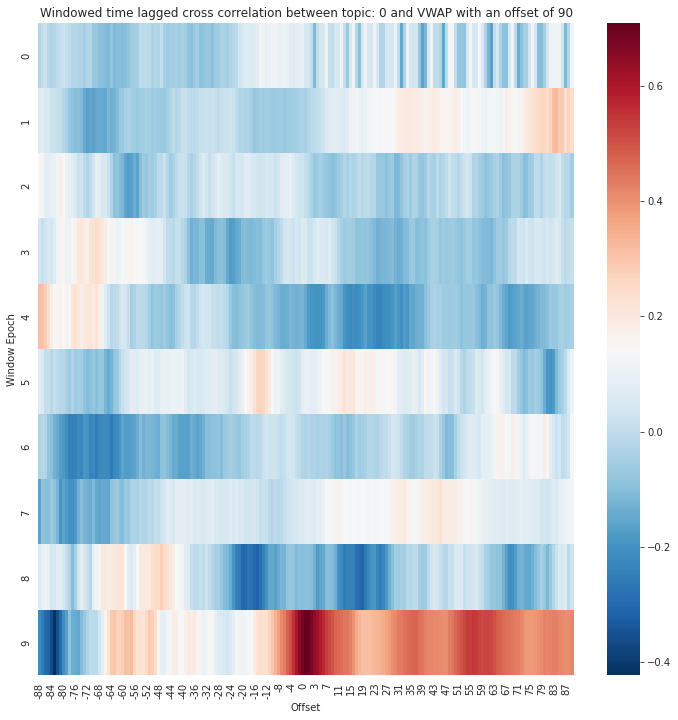

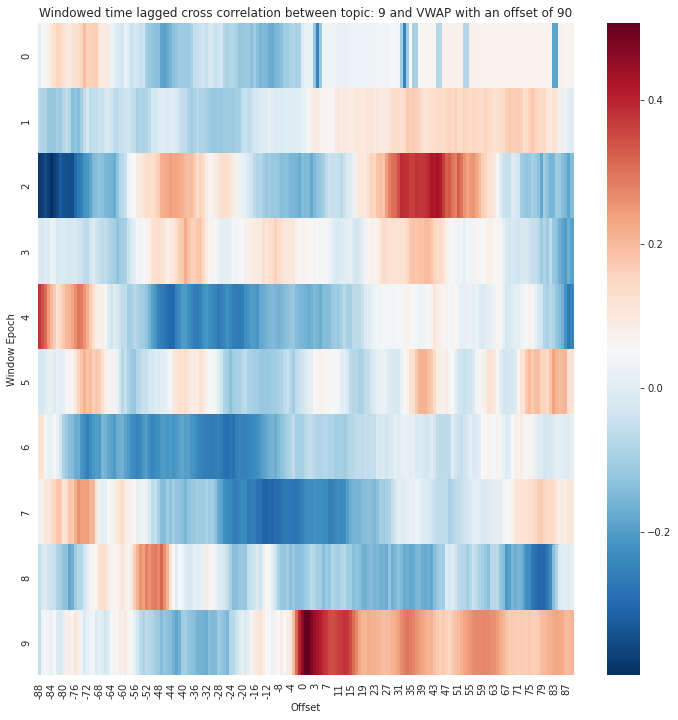

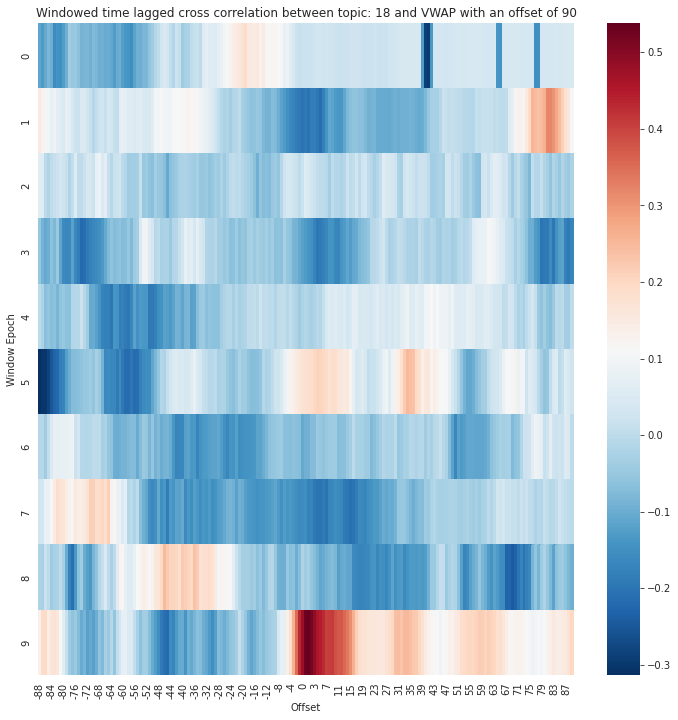

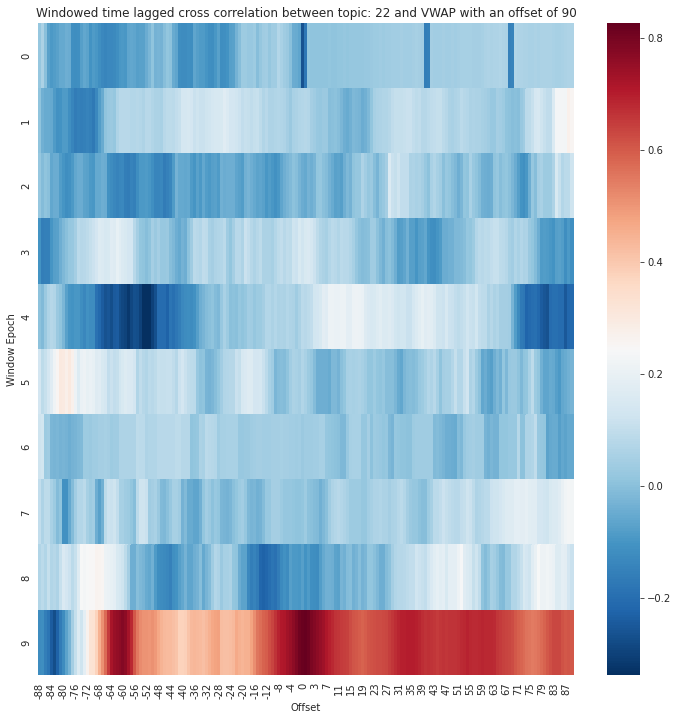

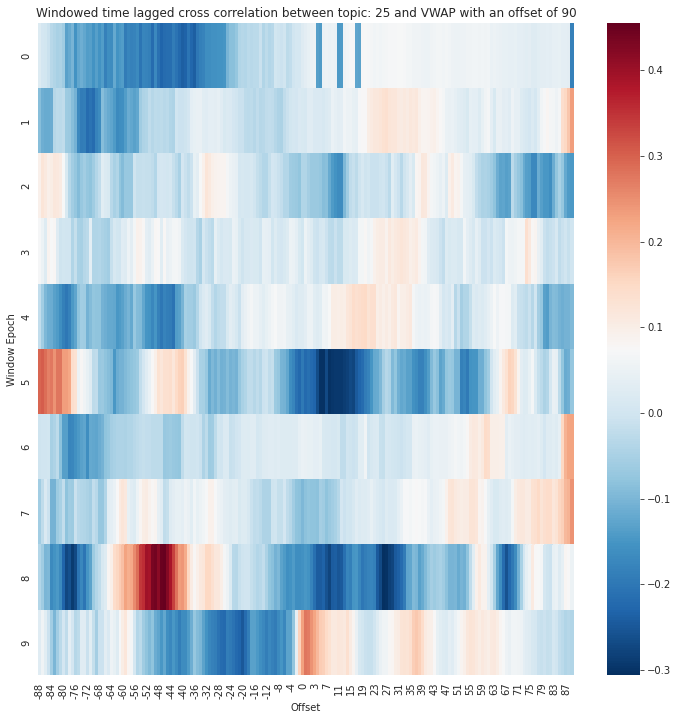

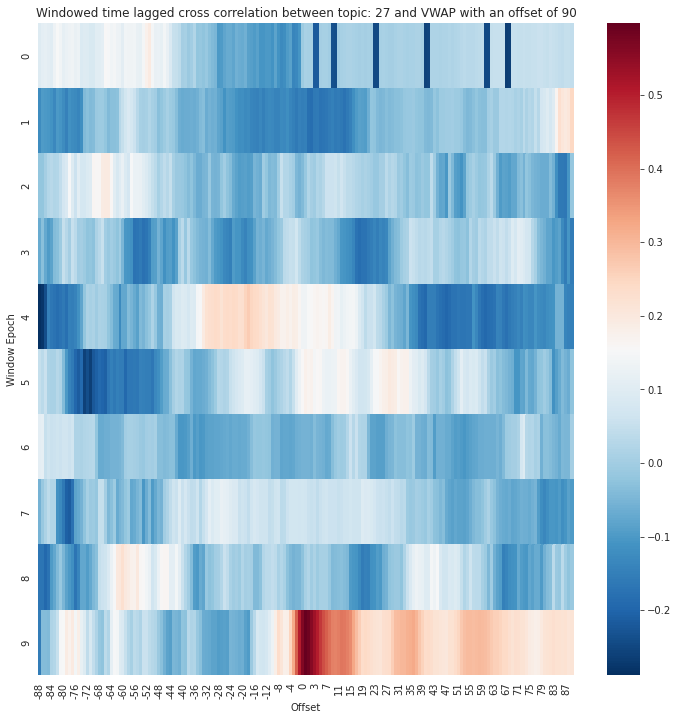

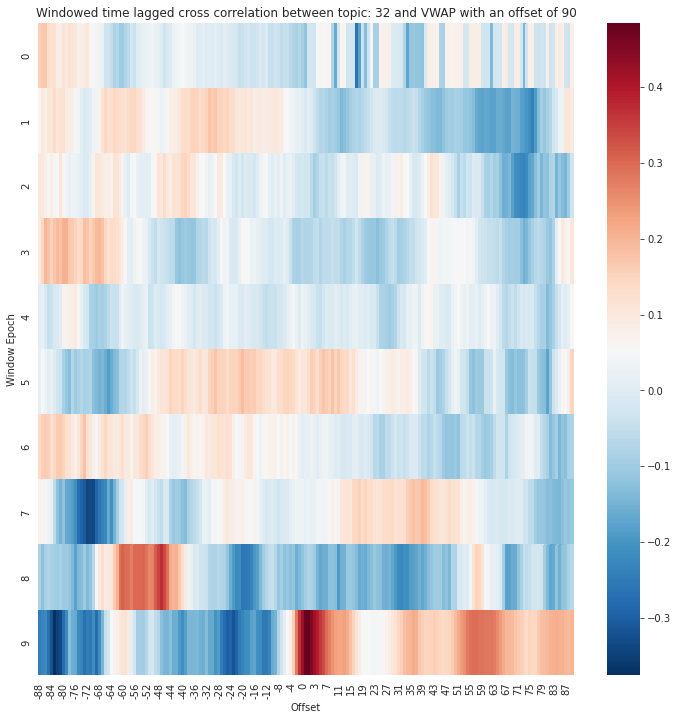

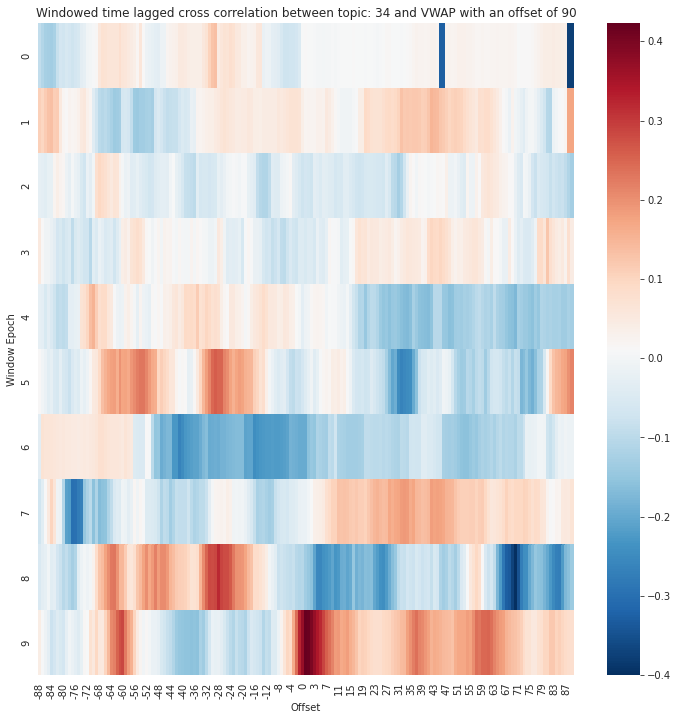

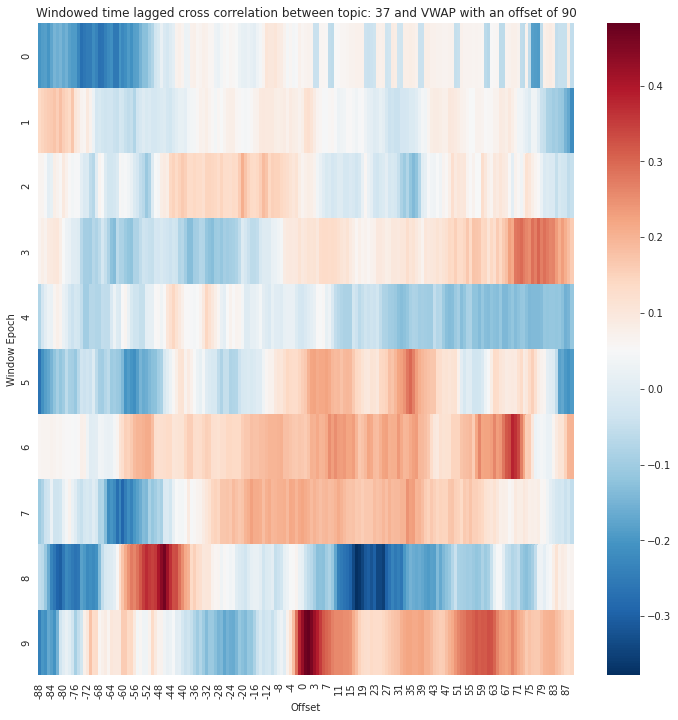

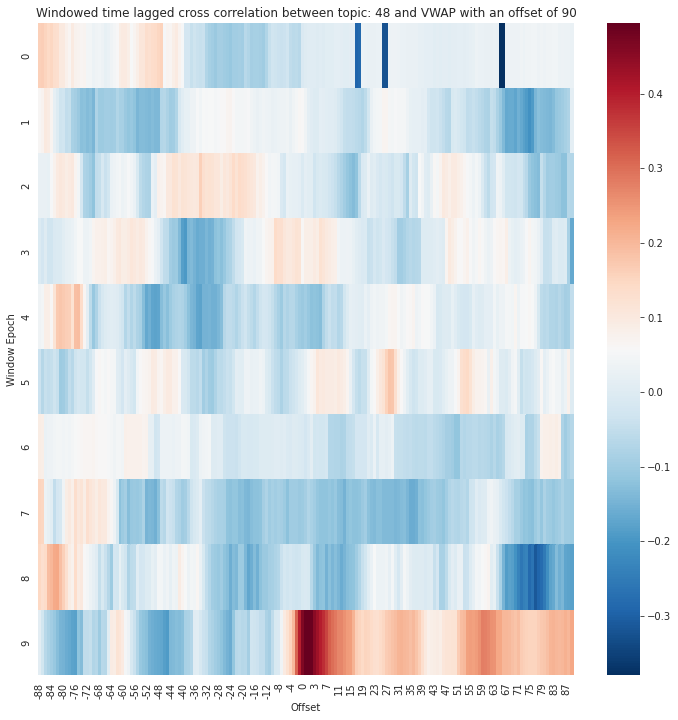

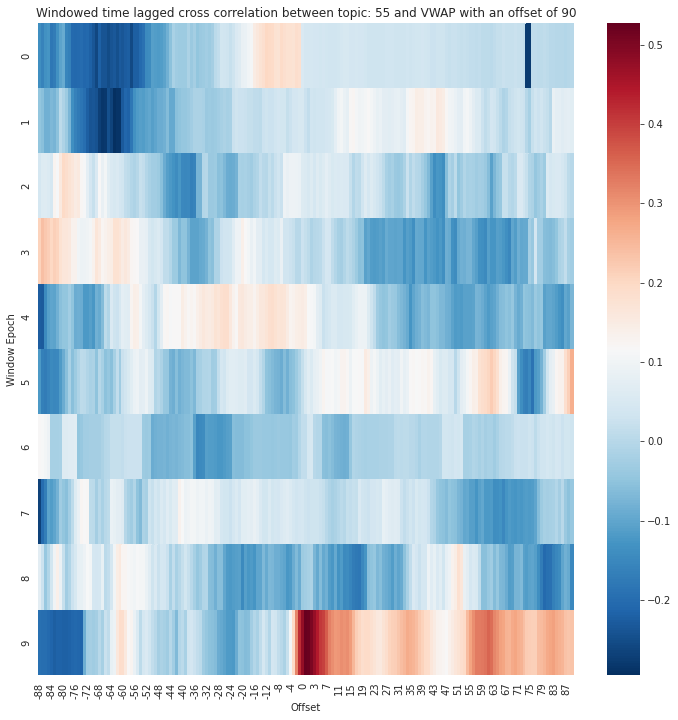

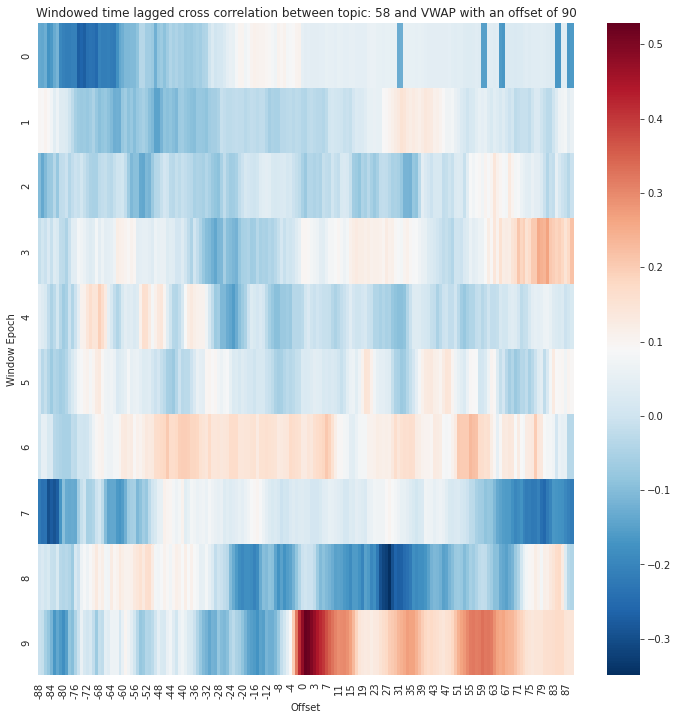

In [44]:
for item in keep_topics:
    wtlcc(merged, item, 'VWAP',no_splits=10, abs_bounds=90)

### WTLCC Results:

In the above figure we create splits of roughly 6 month windows of time to see if there were any leader follower relationships over a period of +- 90 days.

While there are sporadic instances over each time period, the last band is of most interest, as each value shows a synchronicity with the gme VWAP at 0-offset, with the exception of topic #22; this topic shows a strong leader relationship between the the posts and comments relating to a short squeeze of gamestop stocks to gamestop stock VWAP at an offset of -60.

With the identified beginning of the short squeeze being Jan. 11, 2021, this would put the origin of these increased comments sometime in early-mid Nov.

In [45]:
def two_series_dtw(frame, col_1, col_2, metric='euclidean'):
    series_1 = frame[col_1].interpolate().values
    series_2 = frame[col_2].interpolate().values

    d, cost_matrix, acc_cost_matrix, path= accelerated_dtw(series_1, series_2, dist=metric)
    _, ax = plt.subplots(figsize=(10,10))
    ax.imshow(acc_cost_matrix.T, origin='lower', cmap='Greys', interpolation='nearest')
    ax.plot(path[0],path[1],'green')
    ax.set_xlabel(f'Topic {col_1}')
    ax.set_ylabel(f'{col_2}')
    ax.set_title(f'DTW Min path with min distance {d:.2f}')
    plt.show()

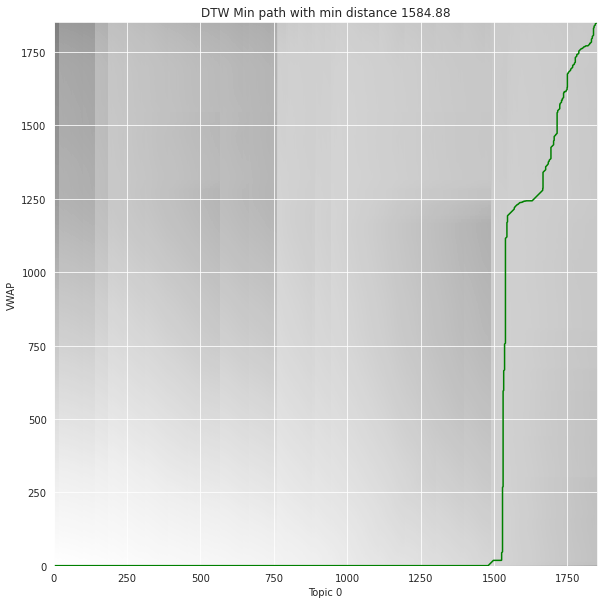

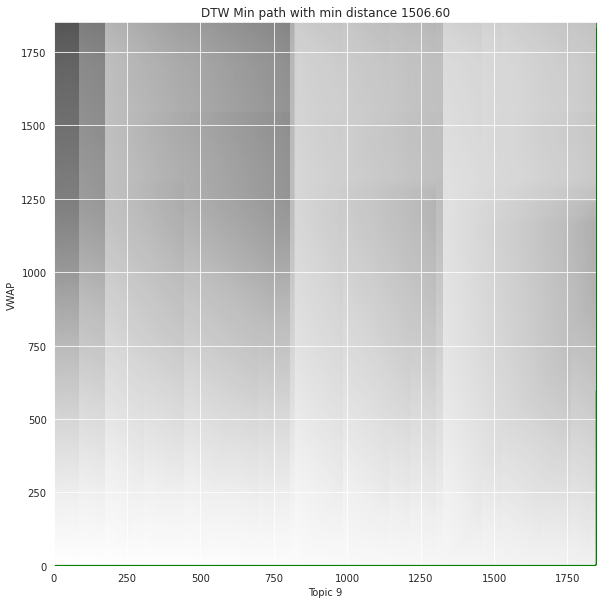

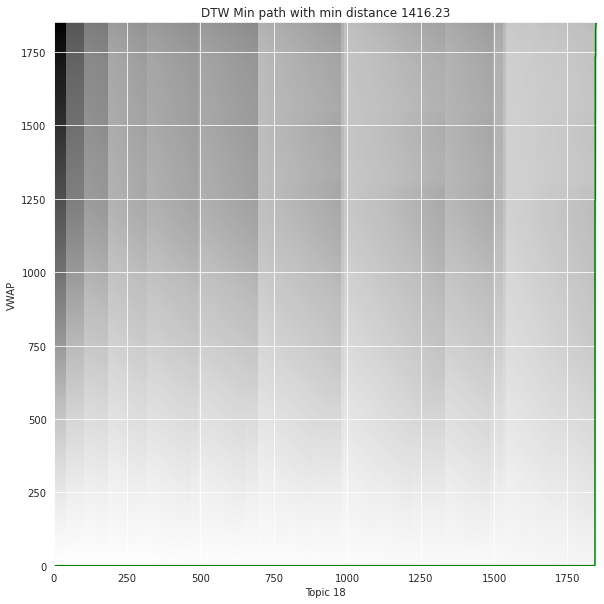

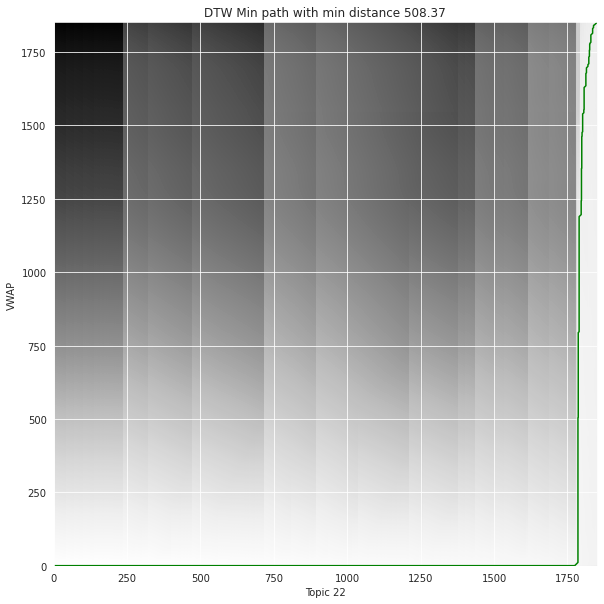

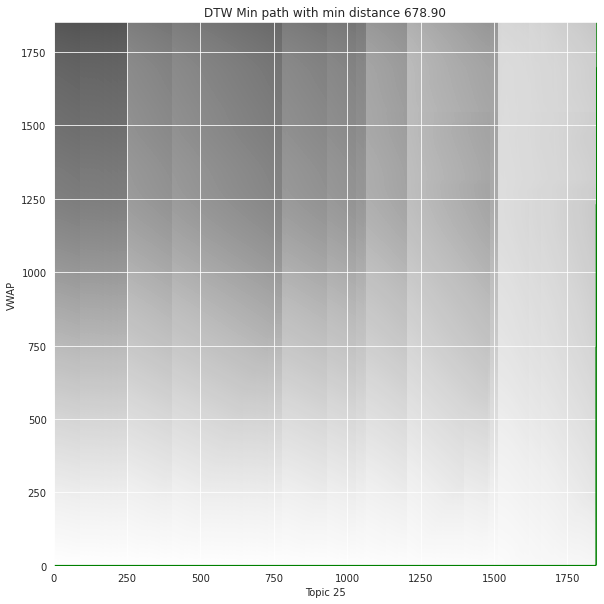

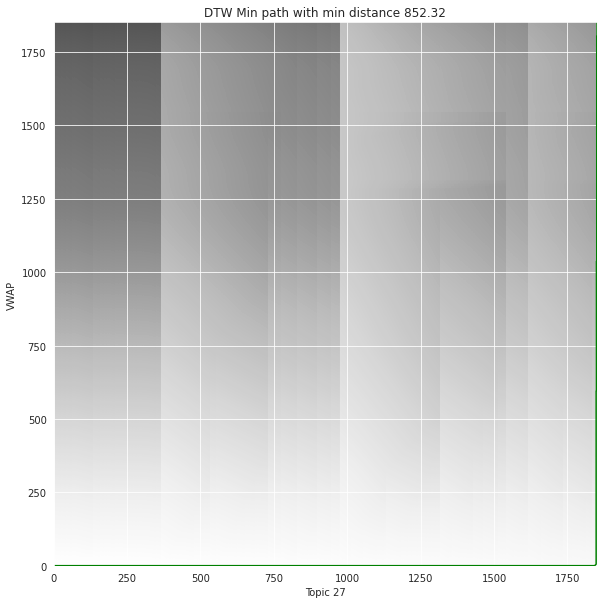

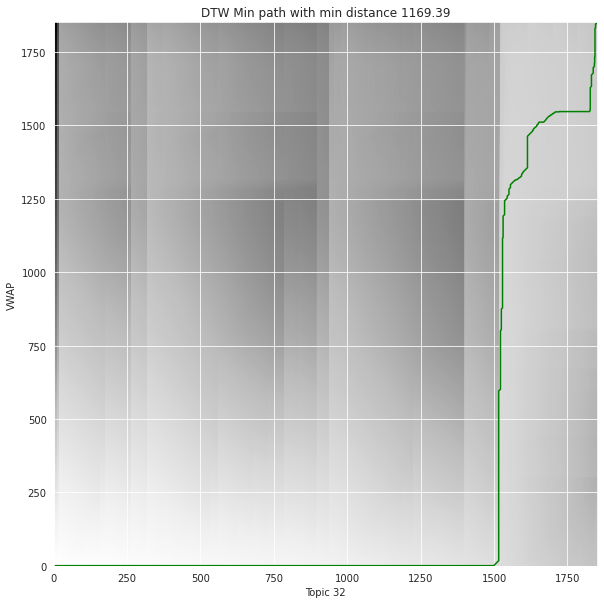

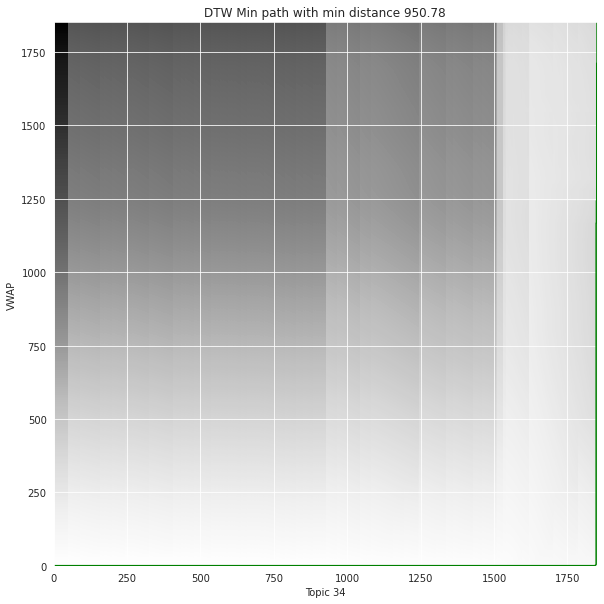

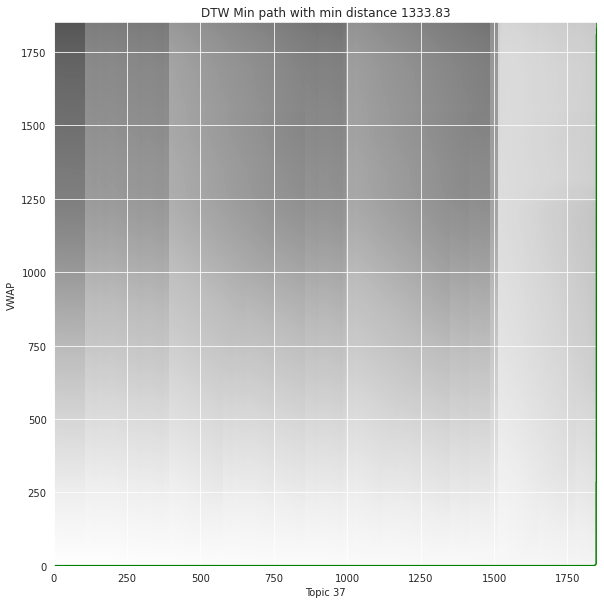

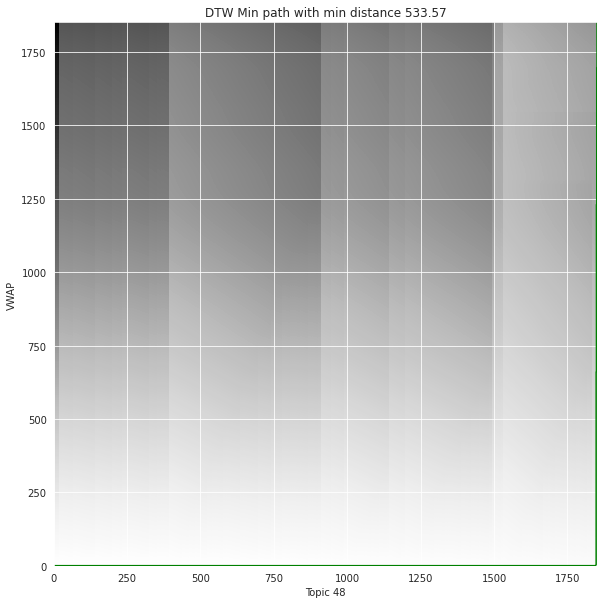

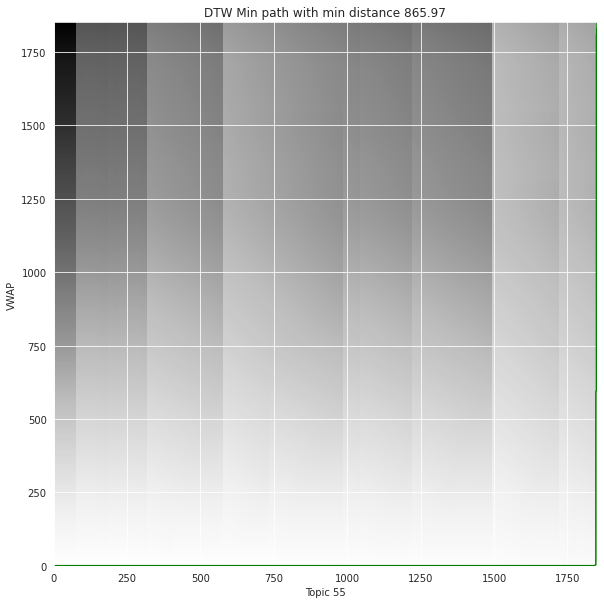

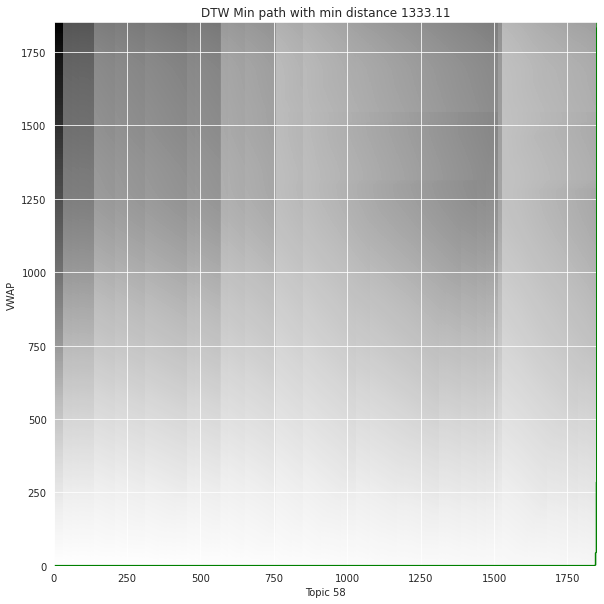

In [46]:
for item in keep_topics:
    two_series_dtw(merged, item, 'VWAP')

We see in the above figures interesting behavior where certain topics have non-trivial paths in rouhgly the last 4 months of data.

### RSI

Here we repeat the above tests but against the $GME RSI.

In [47]:
for item in keep_topics:
    print(f'topic number:{item}',np.corrcoef(merged.loc[:'2020-12-01'][item], merged.loc[:'2020-12-01']['RSI'])[0,1])

topic number:0 0.13667474667161783
topic number:9 0.026356388627014928
topic number:18 0.0863073193411341
topic number:22 0.12724876494388476
topic number:25 0.061690960205015195
topic number:27 0.04829100161754666
topic number:32 0.10328191651681981
topic number:34 0.07271031516209556
topic number:37 0.09824915928924892
topic number:48 0.05337803761131382
topic number:55 0.07935910346238274
topic number:58 0.07587638162368729


In [48]:
for item in keep_topics:
    print(f'topic number:{item}',np.corrcoef(merged.loc['2020-12-02':][item], merged.loc['2020-12-02':]['RSI'])[0,1])

topic number:0 0.394062314112075
topic number:9 0.21390037167045836
topic number:18 0.3346736396514484
topic number:22 0.5478363902049587
topic number:25 0.18626858887882894
topic number:27 0.3491730400378779
topic number:32 0.28001420429212504
topic number:34 0.29806889133166925
topic number:37 0.21764485315003138
topic number:48 0.2718157292779675
topic number:55 0.21797453345677323
topic number:58 0.1501835127102404


In [49]:
for item in keep_topics:
    print(f'topic number:{item}',crosscorr(merged[item], merged['RSI']))

topic number:0 0.17963857568527308
topic number:9 0.04768919788208004
topic number:18 0.11646162455632805
topic number:22 0.18795689765681783
topic number:25 0.07708764832771615
topic number:27 0.08117318872331558
topic number:32 0.12953721203391805
topic number:34 0.09115731993117968
topic number:37 0.12105356571703924
topic number:48 0.08340445299761905
topic number:55 0.10556340999255216
topic number:58 0.09901948051399771


#### WTLCC RSI

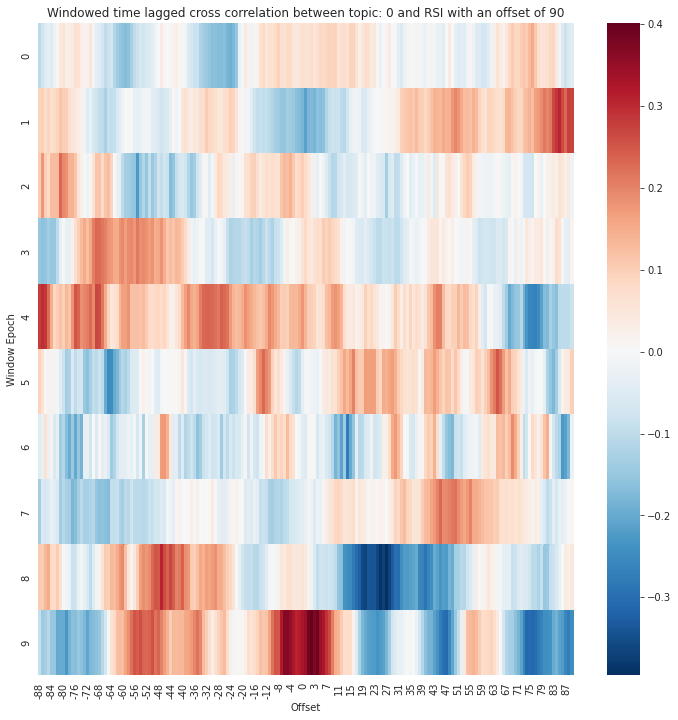

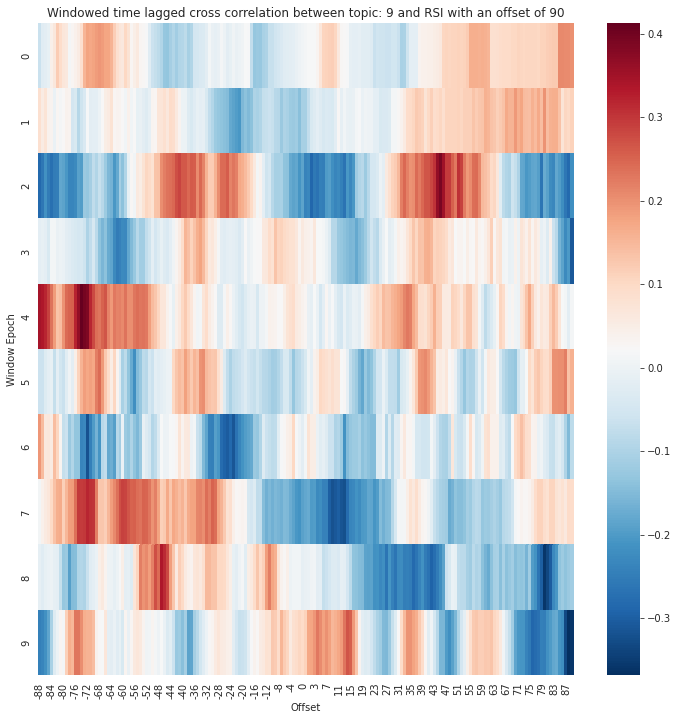

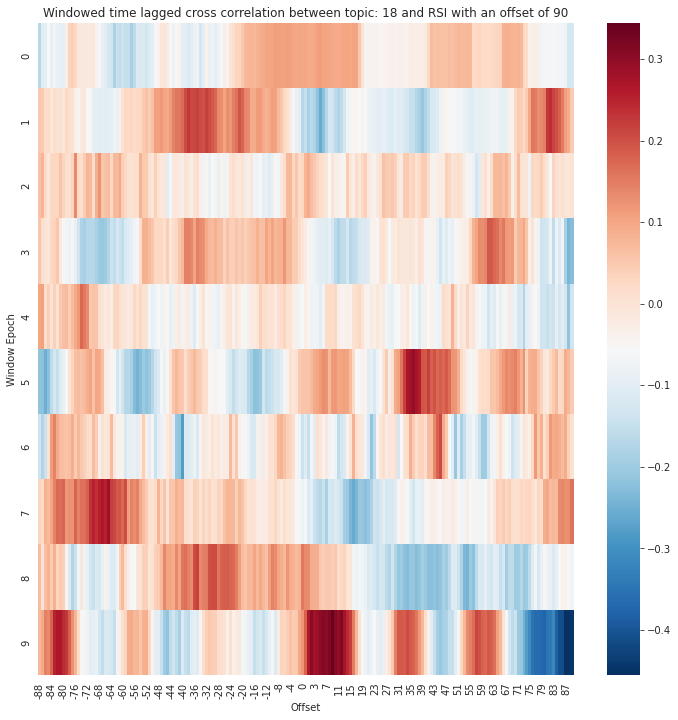

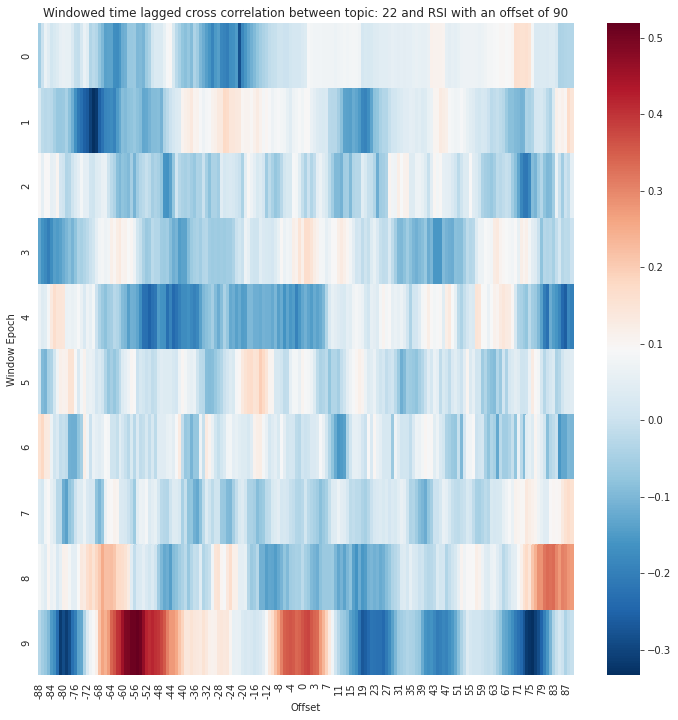

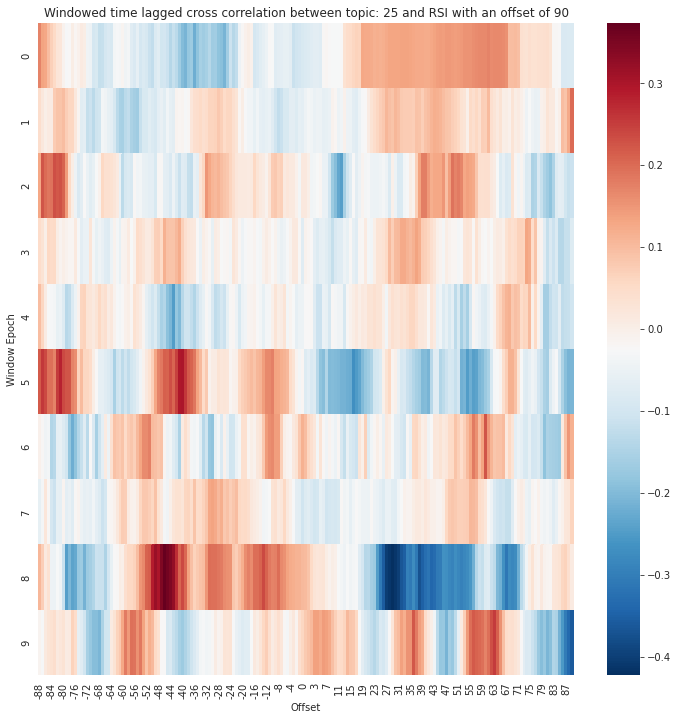

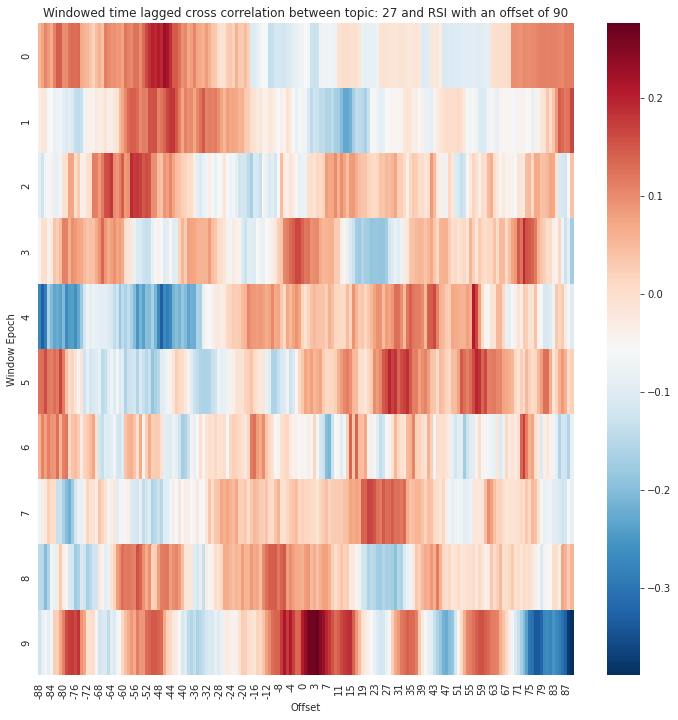

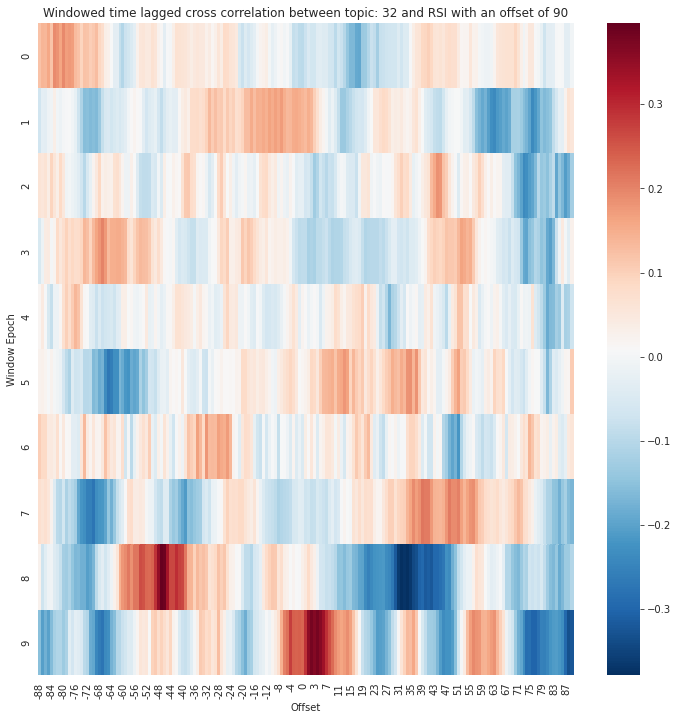

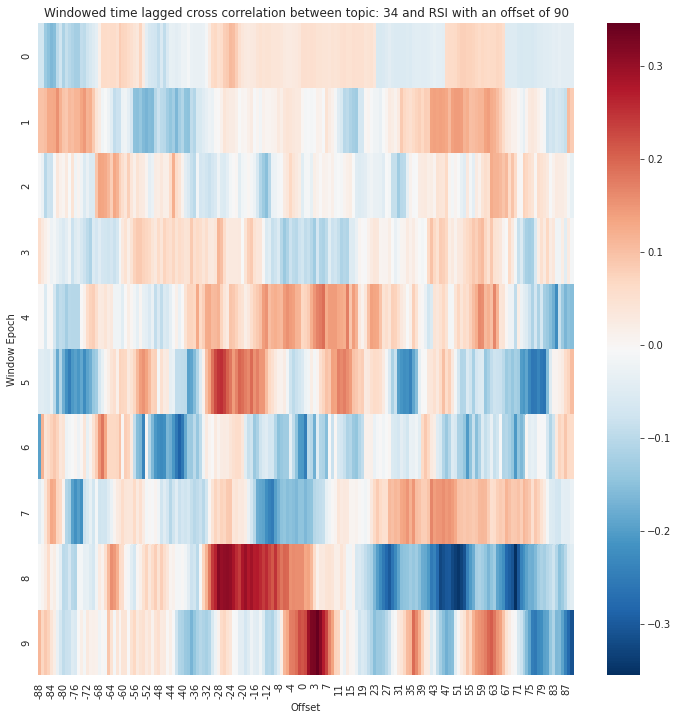

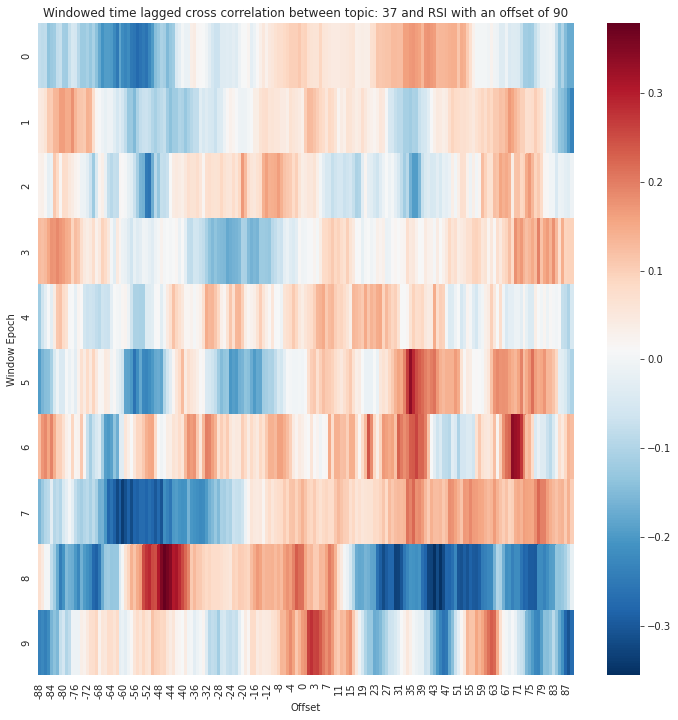

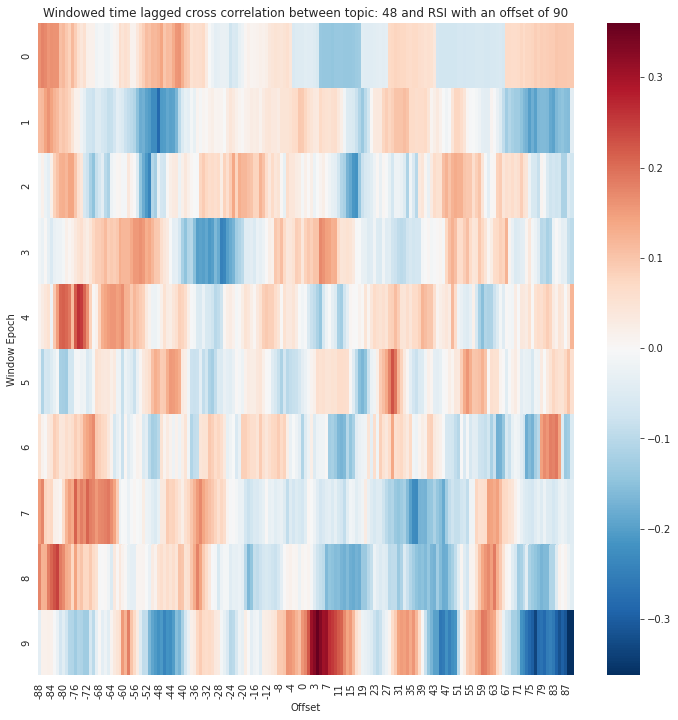

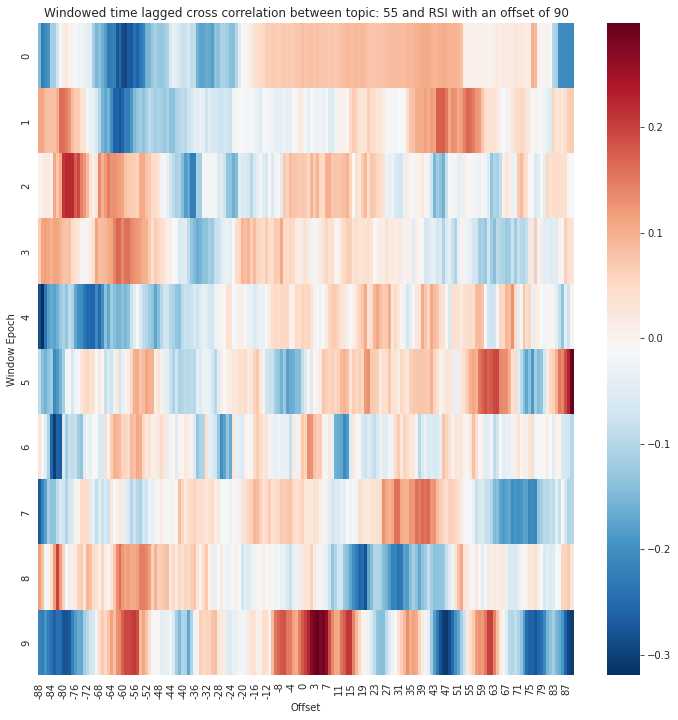

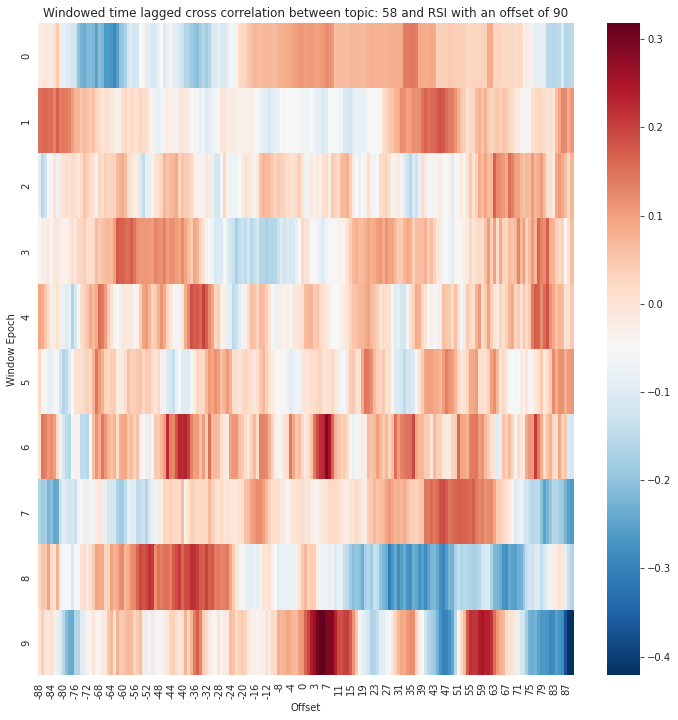

In [50]:
for item in keep_topics:
    wtlcc(merged, item, 'RSI',no_splits=10, abs_bounds=90)

#### DTW RSI

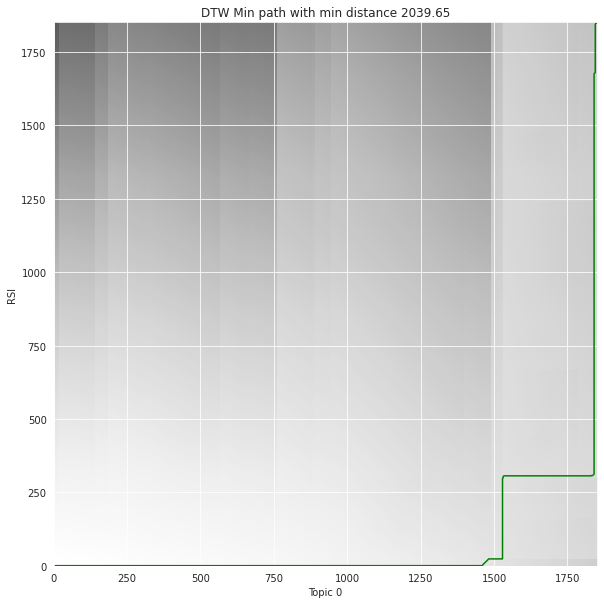

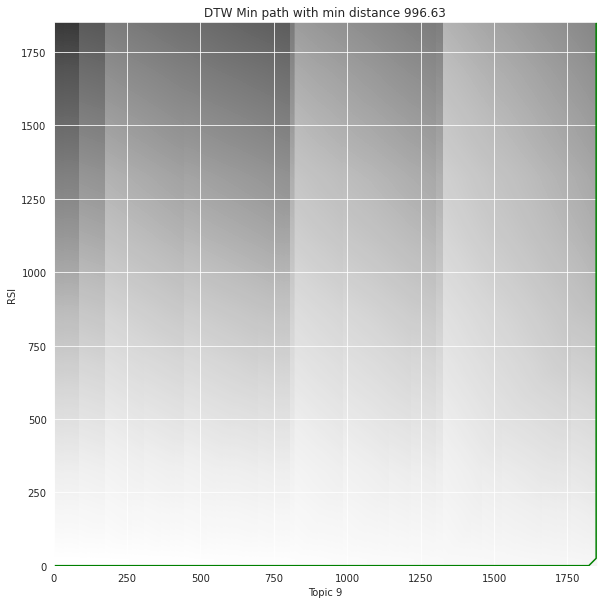

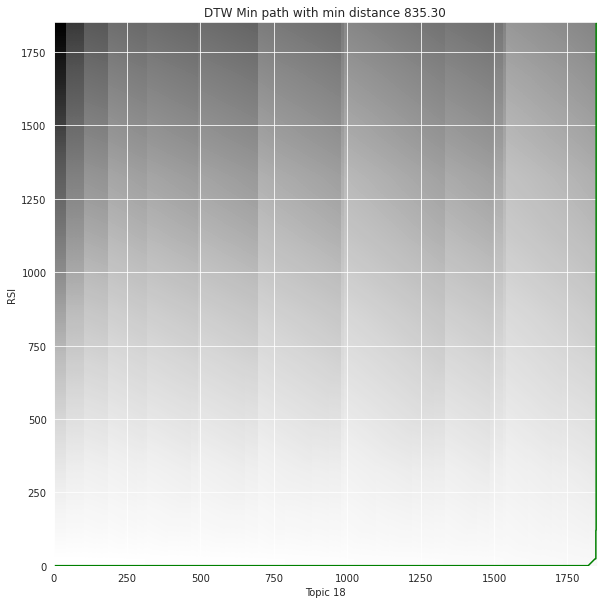

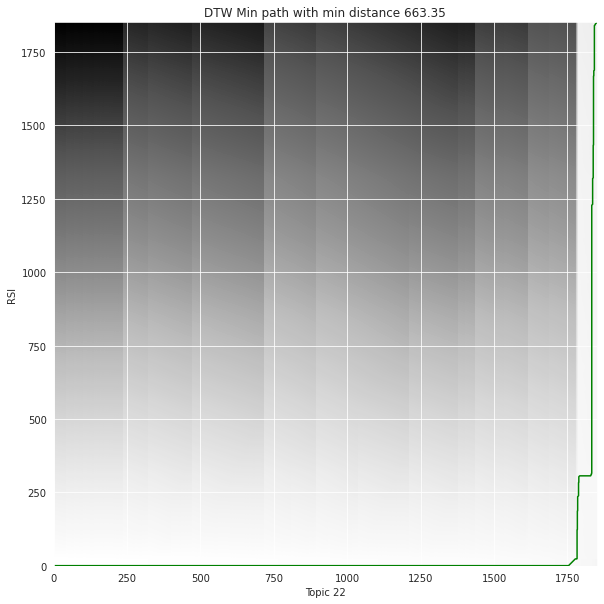

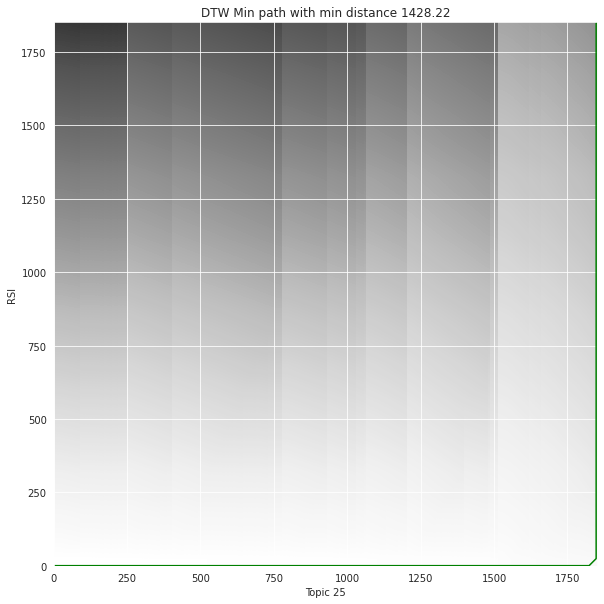

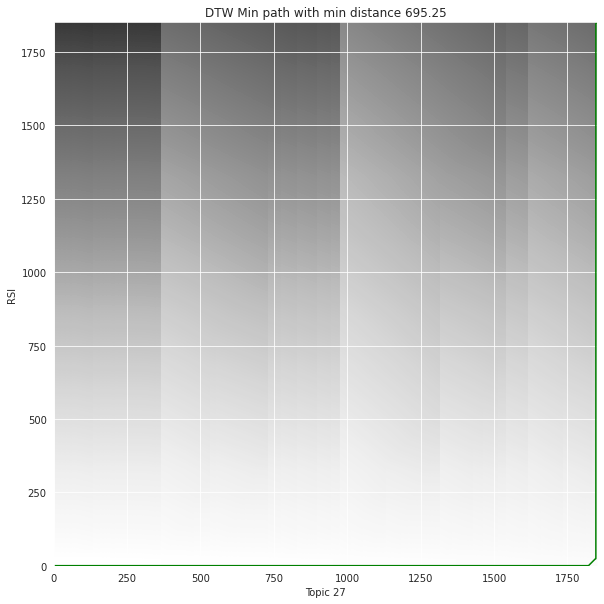

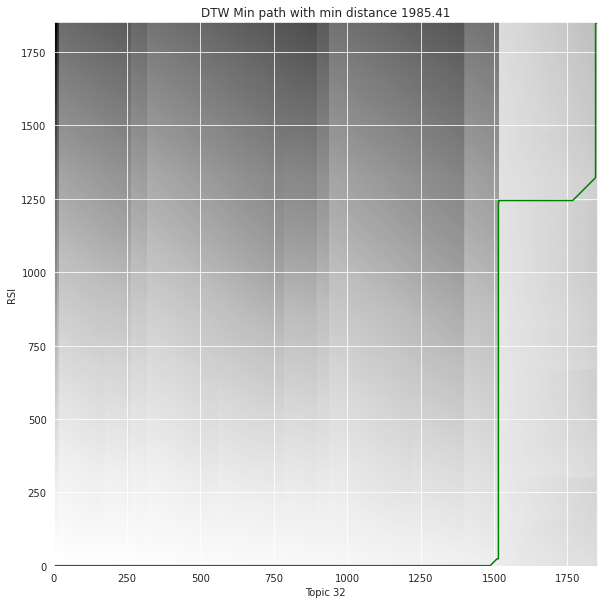

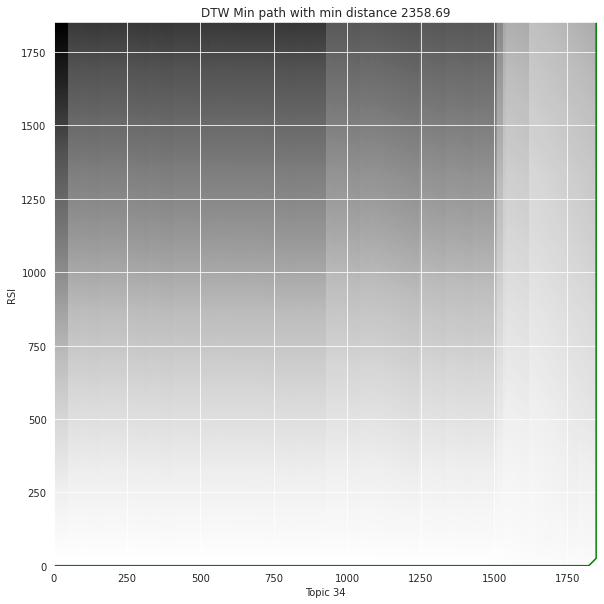

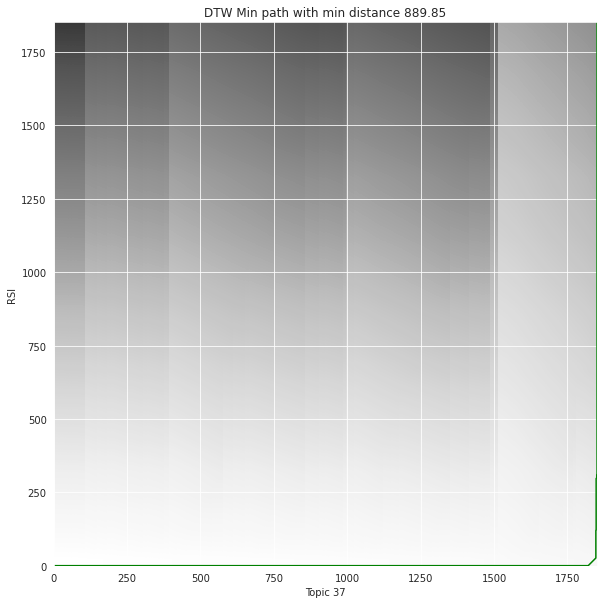

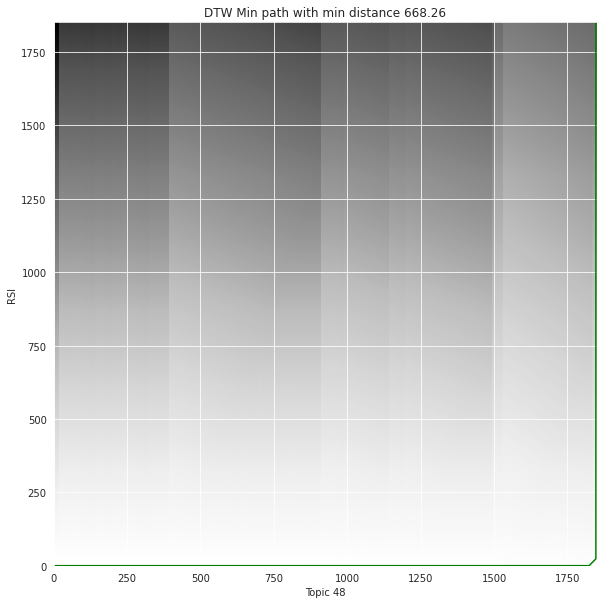

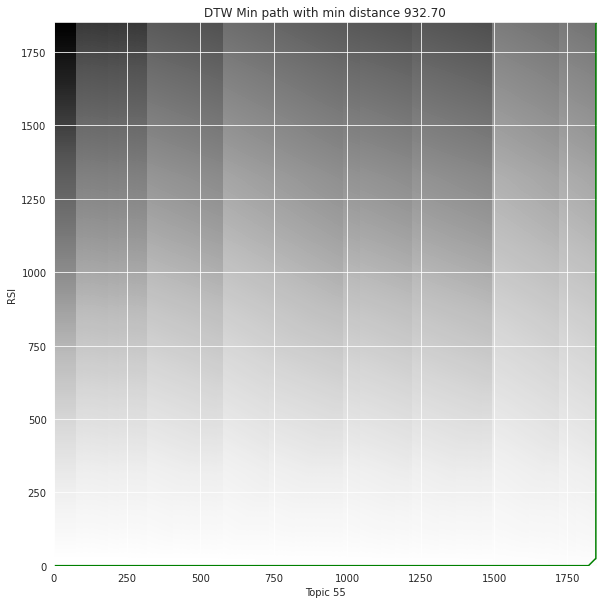

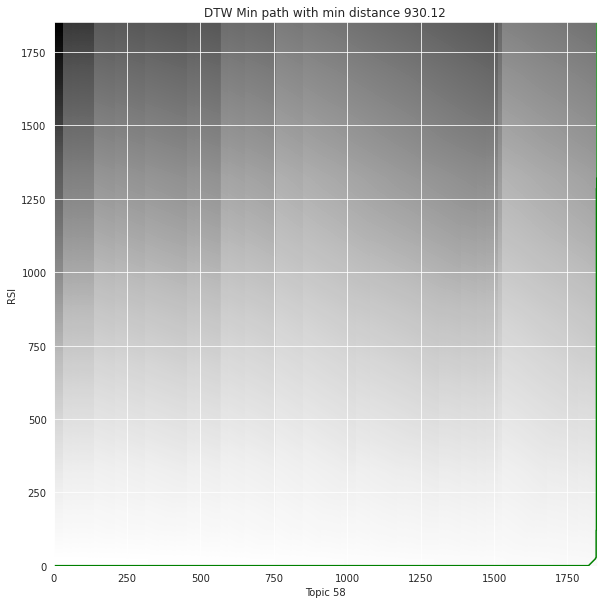

In [51]:
for item in keep_topics:
    two_series_dtw(merged, item, 'RSI')

In [98]:
def adfuller_results(series, differencing = 0, mlag=None):
    
    if differencing == 0:
        res = adfuller(series, maxlag=mlag)
    elif differencing == 1:
        res = adfuller(series.diff().dropna(), maxlag=mlag)
    elif differencing == 2:
        res = adfuller(series.diff().diff().dropna(), maxlag=mlag)

    adf, pval, lags, nobs = res[0], res[1], res[2], res[3]
    diff_count=0
    if pval > 0.05:
        print(f'Series not stationary with p-value of: {pval}\n applying difference')
        pass
    else:
        print(f'Series is stationary with {differencing}-order differencing')
        print(f'adfuller statistic: {adf}')
        print(f'p-value: {pval}')
        print(f'number of lags used: {lags}')
        print(f'number of observations:{nobs}')
        print('critical values for stationarity\n',f'{res[4]}')

In [114]:
adfuller_results(merged['VWAP'], 1, 40)

Series is stationary with 1-order differencing
adfuller statistic: -3.827951235045569
p-value: 0.0026339405239586998
number of lags used: 23
number of observations:1827
critical values for stationarity
 {'1%': -3.433934297502219, '5%': -2.8631232673540117, '10%': -2.5676128776645637}


In [112]:
adfuller_results(merged['RSI'],mlag=40)

Series is stationary with 0-order differencing
adfuller statistic: -8.207505079655123
p-value: 6.960436418199821e-13
number of lags used: 2
number of observations:1849
critical values for stationarity
 {'1%': -3.433891590943719, '5%': -2.8631044140606456, '10%': -2.5676028389397336}


In [108]:
adfuller_results(merged[22],1)

Series is stationary with 1-order differencing
adfuller statistic: -9.143044693839892
p-value: 2.8155225575775107e-15
number of lags used: 19
number of observations:1831
critical values for stationarity
 {'1%': -3.433926456232207, '5%': -2.863119805756803, '10%': -2.5676110344808043}


In [113]:
adfuller_results(merged[0],1,mlag=40)

Series is stationary with 1-order differencing
adfuller statistic: -7.428026560622775
p-value: 6.470741623797146e-11
number of lags used: 33
number of observations:1817
critical values for stationarity
 {'1%': -3.4339540519343137, '5%': -2.863131988080628, '10%': -2.5676175211639354}


### Granger causality:

Given the results from the above graphical explorations of trends and correlations in the datasets. There is interesting behavior to be found in the relationship between topic number 22 and both the RSI and VWAP for GameStop in the final 6 month split of the data, we see in both instances the same leader influence. So the question can be raised: "Were gamestop stock prices granger caused by the number of posts and comments about short-squeezing the stock?"

Here we try to answer that question with granger-causality tests: essentiall trying to say whether or not the daily frequence of short squeeze references would have served as a predictor of price.

To begin we first test the relationship in one direction:

null hypothesis: The daily frequencies of short squeeze posts do not increase stock prices.

alternatice: They do.



In [122]:
grangercausalitytests(merged[[22,'VWAP']].diff().dropna(),maxlag=5,addconst=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.8216  , p=0.0507  , df_denom=1847, df_num=1
ssr based chi2 test:   chi2=3.8278  , p=0.0504  , df=1
likelihood ratio test: chi2=3.8238  , p=0.0505  , df=1
parameter F test:         F=3.8216  , p=0.0507  , df_denom=1847, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9998  , p=0.1357  , df_denom=1844, df_num=2
ssr based chi2 test:   chi2=4.0105  , p=0.1346  , df=2
likelihood ratio test: chi2=4.0061  , p=0.1349  , df=2
parameter F test:         F=1.9998  , p=0.1357  , df_denom=1844, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=15.0159 , p=0.0000  , df_denom=1841, df_num=3
ssr based chi2 test:   chi2=45.2191 , p=0.0000  , df=3
likelihood ratio test: chi2=44.6748 , p=0.0000  , df=3
parameter F test:         F=15.0159 , p=0.0000  , df_denom=1841, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=13.3697 , p=0.

{1: ({'lrtest': (3.823843643737291, 0.050528202202952864, 1),
   'params_ftest': (3.821590960045911, 0.05074682305737303, 1847.0, 1.0),
   'ssr_chi2test': (3.827798200370265, 0.05040911112920366, 1),
   'ssr_ftest': (3.8215909600453393, 0.05074682305738973, 1847.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (4.00613644036639, 0.13492068115957248, 2),
   'params_ftest': (1.9998172644183496, 0.13565347885558435, 1844.0, 2.0),
   'ssr_chi2test': (4.010479524847379, 0.13462801308686806, 2),
   'ssr_ftest': (1.999817264418217, 0.13565347885559043, 1844.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (44.67475665872553, 1.08488842976568e-09, 3),
   'params_ftest': (15.015949419874788, 1.1716000923418209e-09, 1841.0, 3.0),
   'ssr_chi2test': (45.219132853767086, 8.31180642841277e-10, 3),
   'ssr_ftest': (15.01594941987468, 1.1716000923419373e-09, 1841.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
     

We see that after just 4 lags there the resulting significance levels of the different tests suggest that the topic frequencies do increase price.

The next step is to test the converse:

To begin we first test the relationship in one direction:

null hypothesis: Stock price increase does not influence the number of daily postings about shorting gamestop stocks.

alternatice: Price does have an influence.


In this instance we are looking for significance at the same lag number as before. Since this is an iff type "proof" both directions must be valid for the initial assumption, i.e. if we find both to be a cause for the other that is bad.

In [124]:
grangercausalitytests(merged[['VWAP',22]].diff().dropna(),maxlag=5,addconst=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9676  , p=0.3254  , df_denom=1847, df_num=1
ssr based chi2 test:   chi2=0.9692  , p=0.3249  , df=1
likelihood ratio test: chi2=0.9689  , p=0.3249  , df=1
parameter F test:         F=0.9676  , p=0.3254  , df_denom=1847, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.8173  , p=0.0222  , df_denom=1844, df_num=2
ssr based chi2 test:   chi2=7.6553  , p=0.0218  , df=2
likelihood ratio test: chi2=7.6395  , p=0.0219  , df=2
parameter F test:         F=3.8173  , p=0.0222  , df_denom=1844, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6740  , p=0.1706  , df_denom=1841, df_num=3
ssr based chi2 test:   chi2=5.0410  , p=0.1688  , df=3
likelihood ratio test: chi2=5.0341  , p=0.1693  , df=3
parameter F test:         F=1.6740  , p=0.1706  , df_denom=1841, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.8540  , p=0.

{1: ({'lrtest': (0.9689265383422025, 0.32494804310297254, 1),
   'params_ftest': (0.9676086736551464, 0.32540612759925136, 1847.0, 1.0),
   'ssr_chi2test': (0.9691803174124827, 0.32488469046106383, 1),
   'ssr_ftest': (0.9676086736545165, 0.32540612759940524, 1847.0, 1)},
   array([[0., 1., 0.]])]),
 2: ({'lrtest': (7.639543912095178, 0.021932801966855743, 2),
   'params_ftest': (3.817323283077325, 0.02216052636042826, 1844.0, 2.0),
   'ssr_chi2test': (7.655347885477562, 0.021760172214883633, 2),
   'ssr_ftest': (3.817323283077508, 0.022160526360426668, 1844.0, 2)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'lrtest': (5.034129521071009, 0.1693150041305791, 3),
   'params_ftest': (1.673965936388415, 0.17059856639093085, 1841.0, 3.0),
   'ssr_chi2test': (5.040992477641113, 0.1688199654626641, 3),
   'ssr_ftest': (1.6739659363883999, 0.17059856639093085, 1841.0, 3)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [

Here we fail to reject the null hypothesis that price increase does not influence short squeeze mentions, and we can reach the conclusion that posts about short squeezing gamestop stocks increased price.

In [ ]:
df_one[(df_one.dt>'2020-11-01') &(df_one.dt<'2020-11-30') & (df_one.preprocessed_str.str.contains('gme'))]

id  ... topic_pcnt
51988  jmwu8o  ...   0.890498
52024  jnde6b  ...   0.300163
52067  jnu8gl  ...   0.311736
52144  jps8cs  ...   0.525951
52233  jr1hxl  ...   0.499194
52193  jqsjo0  ...   0.270072
52176  jqmbuh  ...   0.401921
52207  jqxvnq  ...   0.289306
52342  jrous4  ...   0.266500
52333  jrn8l2  ...   0.536270
52318  jrivuo  ...   0.190187
52506  jt5t34  ...   0.315156
53070  jxbf9a  ...   0.453368
53188  jxz10g  ...   0.435220
53178  jxwywj  ...   0.466392
53176  jxwinr  ...   0.388572
53173  jxw62x  ...   0.587143
53112  jxn70w  ...   0.259838
53391  jzqior  ...   0.273561
53302  jzdsmh  ...   0.693077
53311  jzik6x  ...   0.480512
53324  jzjin2  ...   0.834536
53469  k032jd  ...   0.603787
53783  k0z2zy  ...   0.299423
53803  k10c6g  ...   0.538942
53647  k0r8ww  ...   0.362281
54012  k1nek9  ...   0.326447
54014  k1np2q  ...   0.427565
53995  k1lcib  ...   0.521391
53931  k1dil9  ...   0.768101
54263  k2625l  ...   0.291542
54338  k29omq  ...   0.278871
54342  k29x3n  ...   0.719410
54312  k28742  ...   0.241442
54079  k1west  ...   0.577776
54190  k23mwv  ...   0.385170
54148  k22o41  ...   0.753674
54146  k22kdt  ...   0.616442
54457  k2ooty  ...   0.408261
54463  k2pbpt  ...   0.666039
54454  k2o7zk  ...   0.391629
54504  k2x1y5  ...   0.351038
54473  k2r9df  ...   0.417548
54479  k2su3w  ...   0.780273
54491  k2ul1z  ...   0.296085
54378  k2dmnw  ...   0.436743
54422  k2hyhu  ...   0.480929
54423  k2i057  ...   0.575592
54430  k2j2cg  ...   0.298693
54567  k38nfh  ...   0.394040
54576  k3b23n  ...   0.255604
54592  k3dcqo  ...   0.631477
54615  k3ilif  ...   0.504027
54563  k37kcp  ...   0.552007
54532  k31l1p  ...   0.282130
54523  k2zwd5  ...   0.402065
54511  k2xz2y  ...   0.983005
54535  k32h0m  ...   0.233191
54556  k360m8  ...   0.264976

[59 rows x 10 columns]